# Counting Words of The Odyssey

In [1]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.appName('Counting Words of The Odyssey').master("local[*]").getOrCreate()

In [2]:
# 'local[*]' means that the SparkSession uses all possible threads on my computer
spark.sparkContext

<SparkContext master=local[*] appName=Counting Words of The Odyssey>

In [3]:
# Retrieve the full text of The Odyssey from mit.edu
url = "http://classics.mit.edu/Homer/odyssey.mb.txt"
spark.sparkContext.addFile(url)

odyssey_preprocess = ''

with open(SparkFiles.get("odyssey.mb.txt")) as f:
    # removes header and footer ~11 lines each
    odyssey_preprocess = f.readlines()[11:-11]
    
# Prints type --> which is list
print(type(odyssey_preprocess))

# Prints first 10 elements
print(odyssey_preprocess[0:10])

<class 'list'>
['\n', 'BOOK I\n', '\n', 'Tell me, O muse, of that ingenious hero who travelled far and wide\n', 'after he had sacked the famous town of Troy. Many cities did he visit,\n', 'and many were the nations with whose manners and customs he was acquainted;\n', 'moreover he suffered much by sea while trying to save his own life\n', 'and bring his men safely home; but do what he might he could not save\n', 'his men, for they perished through their own sheer folly in eating\n', 'the cattle of the Sun-god Hyperion; so the god prevented them from\n']


In [4]:
# Uses list comprehension to extract each word from the list
# Removes the '\n' during the process
odyssey_preprocess = ''.join([str(word) for word in odyssey_preprocess]) 

# Prints first 1000 characters
print(odyssey_preprocess[0:1000])


BOOK I

Tell me, O muse, of that ingenious hero who travelled far and wide
after he had sacked the famous town of Troy. Many cities did he visit,
and many were the nations with whose manners and customs he was acquainted;
moreover he suffered much by sea while trying to save his own life
and bring his men safely home; but do what he might he could not save
his men, for they perished through their own sheer folly in eating
the cattle of the Sun-god Hyperion; so the god prevented them from
ever reaching home. Tell me, too, about all these things, O daughter
of Jove, from whatsoever source you may know them. 

So now all who escaped death in battle or by shipwreck had got safely
home except Ulysses, and he, though he was longing to return to his
wife and country, was detained by the goddess Calypso, who had got
him into a large cave and wanted to marry him. But as years went by,
there came a time when the gods settled that he should go back to
Ithaca; even then, however, when he was amon

In [5]:
# Creates .txt file for the full text of The Odyssey
text_file = open("odyssey.txt", "w")
text_file.write(str(odyssey_preprocess))
# Closes to prevent overwriting it
text_file.close()

In [6]:
# Reads the .txt file into a pyspark DataFrame
odyssey = spark.read.text("odyssey.txt")
print(type(odyssey))
odyssey.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+
|               value|
+--------------------+
|                    |
|              BOOK I|
|                    |
|Tell me, O muse, ...|
|after he had sack...|
|and many were the...|
|moreover he suffe...|
|and bring his men...|
|his men, for they...|
|the cattle of the...|
|ever reaching hom...|
|of Jove, from wha...|
|                    |
|So now all who es...|
|home except Ulyss...|
|wife and country,...|
|him into a large ...|
|there came a time...|
|Ithaca; even then...|
|troubles were not...|
+--------------------+
only showing top 20 rows



In [7]:
# Makes each line an array
lines = odyssey.select(split(col("value"), " ").alias("line"))
lines.show()

+--------------------+
|                line|
+--------------------+
|                  []|
|           [BOOK, I]|
|                  []|
|[Tell, me,, O, mu...|
|[after, he, had, ...|
|[and, many, were,...|
|[moreover, he, su...|
|[and, bring, his,...|
|[his, men,, for, ...|
|[the, cattle, of,...|
|[ever, reaching, ...|
|[of, Jove,, from,...|
|                  []|
|[So, now, all, wh...|
|[home, except, Ul...|
|[wife, and, count...|
|[him, into, a, la...|
|[there, came, a, ...|
|[Ithaca;, even, t...|
|[troubles, were, ...|
+--------------------+
only showing top 20 rows



In [8]:
# Retrieves the words from each array and creates a line for each of the words
words = lines.select(explode(col("line")).alias("word"))
words.show(20, truncate=False)

+---------+
|word     |
+---------+
|         |
|BOOK     |
|I        |
|         |
|Tell     |
|me,      |
|O        |
|muse,    |
|of       |
|that     |
|ingenious|
|hero     |
|who      |
|travelled|
|far      |
|and      |
|wide     |
|after    |
|he       |
|had      |
+---------+
only showing top 20 rows



In [9]:
# Lowers the case of each word
words_lower = words.select(lower(col("word")).alias("word_lower"))
words_lower.show()

+----------+
|word_lower|
+----------+
|          |
|      book|
|         i|
|          |
|      tell|
|       me,|
|         o|
|     muse,|
|        of|
|      that|
| ingenious|
|      hero|
|       who|
| travelled|
|       far|
|       and|
|      wide|
|     after|
|        he|
|       had|
+----------+
only showing top 20 rows



In [10]:
# Removes all punctuation, quotation marks, and other symbols
words_clean = words_lower.select(regexp_extract(col("word_lower"), "[a-z]*", 0).alias("word"))
words_clean.show()

+---------+
|     word|
+---------+
|         |
|     book|
|        i|
|         |
|     tell|
|       me|
|        o|
|     muse|
|       of|
|     that|
|ingenious|
|     hero|
|      who|
|travelled|
|      far|
|      and|
|     wide|
|    after|
|       he|
|      had|
+---------+
only showing top 20 rows



In [11]:
# Removes records with empty strings ('')
words_final = words_clean.select("*").where(col("word") != '')
words_final.show()

+---------+
|     word|
+---------+
|     book|
|        i|
|     tell|
|       me|
|        o|
|     muse|
|       of|
|     that|
|ingenious|
|     hero|
|      who|
|travelled|
|      far|
|      and|
|     wide|
|    after|
|       he|
|      had|
|   sacked|
|      the|
+---------+
only showing top 20 rows



In [12]:
# Retrives the count for each of the words
words_count = words_final.groupBy(col("word")).count()
words_count.show()

+----------+-----+
|      word|count|
+----------+-----+
|     still|  161|
|   persist|    6|
|      some|  258|
|      hope|   35|
|     those|   85|
|    voyage|   34|
|       few|    7|
|likelihood|    1|
|     spoil|    6|
|  phrontis|    1|
|    waters|   15|
|    travel|    6|
|     inner|   12|
|   flashed|    1|
|   embrace|   14|
|   implore|    1|
|       art|    4|
|   pitcher|    1|
|   blossom|    1|
|   reviled|    3|
+----------+-----+
only showing top 20 rows



In [13]:
# Order by desc. count of words
words_desc_order_count = words_count.orderBy("count", ascending=False)

# Top 50 results are shown
words_desc_order_count.show(100)

+----------+-----+
|      word|count|
+----------+-----+
|       the| 5820|
|       and| 4995|
|        to| 3184|
|        of| 3055|
|       you| 1852|
|        he| 1817|
|         a| 1810|
|         i| 1767|
|        in| 1611|
|       for| 1284|
|       his| 1277|
|        as| 1174|
|      with| 1133|
|        it| 1109|
|      that| 1100|
|       him| 1059|
|       was|  947|
|      they|  925|
|        me|  904|
|        on|  839|
|       had|  839|
|       all|  817|
|       but|  794|
|        my|  791|
|        is|  777|
|      have|  766|
|      them|  759|
|      will|  707|
|       not|  689|
|        so|  657|
|       her|  636|
|      your|  629|
|      when|  615|
|       she|  593|
|       who|  589|
|      this|  561|
|   ulysses|  555|
|       are|  553|
|      from|  549|
|      then|  532|
|       one|  523|
|        at|  518|
|        we|  499|
|        by|  479|
|     their|  478|
|      said|  478|
|        be|  477|
|      were|  472|
|     house|  395|
|     about|

In [14]:
# We can export the DataFrame as a .csv file but we have to change the number of partitions of our DF to 1 parition
# to prevent from having 38 partitions of the .csv file
words_desc_order_count.rdd.getNumPartitions()
onePart = words_desc_order_count.repartition(1)
onePart.write.csv('odyssey_word_count.csv')

In [15]:
# Convert PySpark DataFrame to pandas DataFrame
odyssey_pd = words_desc_order_count.toPandas()
print(type(odyssey_pd))

<class 'pandas.core.frame.DataFrame'>


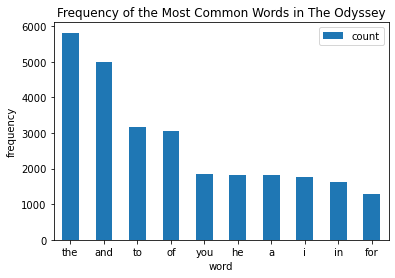

In [16]:
odyssey_pd_subset = odyssey_pd.iloc[:10]
ax = odyssey_pd_subset.plot.bar(x='word', y='count', rot=0)
plt.ylabel('frequency')
plt.title('Frequency of the Most Common Words in The Odyssey')
plt.show()